Questão 1:

<img src = "QUESTÃO 1 - 1.png" width = "600">

<img src = "QUESTÃO 1 - PARAMETROS.png" width = "600">

Importação de bibliotecas:

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, eigh_tridiagonal
import time

# --- Parâmetros Físicos Globais ---
m = 1.0  # Massa padrão dos átomos [kg]
k = 1.0  # Constante elástica das molas [N/m]
m_defeito = 3.0 * m # Massa do átomo de defeito

# --- Configurações de Plotagem ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

## 2. Metodologia e Implementação

O sistema foi modelado numericamente em Python. A dinâmica do sistema é descrita pelo problema de autovalor generalizado:

$$K \vec{u} = \omega^2 M \vec{u}$$

Onde `K` é a matriz de rigidez, `M` é a matriz de massa, $\omega^2$ são as frequências de vibração ao quadrado e $\vec{u}$ são os modos normais.

### 2.1 Implementação da Matriz Dinâmica

A desordem foi introduzida na **matriz de massa M**. Enquanto a matriz de rigidez `K` (que descreve a interação entre os átomos) foi mantida constante, a matriz `M` tornou-se uma matriz diagonal com elementos $M_{ii}$ iguais a `m` para um átomo padrão ou `3m` para um átomo de defeito na posição `i`.

### 2.2 Otimização Computacional

Para os cálculos com N grande, foi implementada uma versão otimizada do solver. Aproveitando a estrutura esparsa do sistema, o problema foi transformado e resolvido com a função `scipy.linalg.eigh_tridiagonal`, que é ordens de magnitude mais rápida que um solver para matrizes densas.

A célula de código a seguir contém a definição de todas as funções utilizadas:
1.  `gerar_cadeia_massas`: Cria os vetores de massa para os três cenários.
2.  `montar_e_resolver_sistema`: A implementação original (densa), usada para a análise detalhada dos autovetores em N=100.
3.  `montar_e_resolver_otimizado`: A implementação otimizada, usada para os cálculos de VDOS em N grande.

In [33]:
def gerar_cadeia_massas(N, fracao_defeitos, tipo_desordem='homogenea', tamanho_grupo=3):
    """Gera o vetor de massas para a cadeia de N átomos."""
    massas = np.full(N, m)
    if tipo_desordem == 'homogenea':
        return massas
    
    num_defeitos = int(N * fracao_defeitos)
    if tipo_desordem == 'aleatoria':
        indices_defeitos = np.random.choice(N, num_defeitos, replace=False)
        massas[indices_defeitos] = m_defeito
        return massas
    
    elif tipo_desordem == 'correlacionada':
        num_grupos = int(np.ceil(num_defeitos / tamanho_grupo))
        defeitos_colocados = 0
        indices_ocupados = set()
        while defeitos_colocados < num_grupos * tamanho_grupo and len(indices_ocupados) < N:
            start_index = np.random.randint(0, N - tamanho_grupo + 1)
            if not any(idx in indices_ocupados for idx in range(start_index, start_index + tamanho_grupo)):
                for i in range(tamanho_grupo):
                    idx = start_index + i
                    massas[idx] = m_defeito
                    indices_ocupados.add(idx)
                defeitos_colocados += tamanho_grupo
        return massas
    
    else:
        raise ValueError("Tipo de desordem desconhecido.")

def montar_e_resolver_sistema(massas, k):
    """
    Versão ORIGINAL (densa). 
    Constrói as matrizes K e M completas.
    Ideal para N pequeno (ex: N=100) quando os autovetores são necessários.
    """
    N = len(massas)
    K = np.diag(np.full(N, 2 * k)) + np.diag(-k * np.ones(N - 1), k=1) + np.diag(-k * np.ones(N - 1), k=-1)
    K[0, 0], K[N-1, N-1] = k, k
    M = np.diag(massas)
    w2, modos = eigh(K, M)
    return w2, modos

def montar_e_resolver_otimizado(massas, k):
    """
    Versão OTIMIZADA (esparsa).
    Não monta as matrizes completas e usa um solver tridiagonal.
    Essencial para calcular a VDOS em sistemas grandes (N >= 1000) de forma eficiente.
    Retorna apenas os autovalores (frequências ao quadrado).
    """
    N = len(massas)
    diag_k = np.full(N, 2 * k)
    diag_k[0], diag_k[N-1] = k, k
    off_diag_k = -k * np.ones(N - 1)
    
    m_sqrt_inv = 1.0 / np.sqrt(massas)
    d = diag_k * (m_sqrt_inv ** 2)
    e = off_diag_k * m_sqrt_inv[:-1] * m_sqrt_inv[1:]
    
    w2 = eigh_tridiagonal(d, e, eigvals_only=True)
    return w2

### 2.3 Função Auxiliar para Visualização

A célula de código a seguir define a função `plotar_modos`, que será utilizada posteriormente para visualizar os autovetores de forma clara e padronizada, exibindo a probabilidade $|u_i|^2$ ao longo da cadeia.

In [34]:
def plotar_modos(modos, w2, indices_modos, massas, titulo):
    """Plota a amplitude ao quadrado de modos normais selecionados."""
    N = len(massas)
    fig, axes = plt.subplots(len(indices_modos), 1, figsize=(14, 2.5 * len(indices_modos)), sharex=True, constrained_layout=True)
    if len(indices_modos) == 1:
        axes = [axes]
        
    fig.suptitle(titulo, fontsize=16)
    posicoes_defeitos = np.where(massas > m)[0]

    for i, idx in enumerate(indices_modos):
        ax = axes[i]
        # Normaliza cada modo para que a área sob a curva seja 1
        modo_amplitude_sq = np.abs(modos[:, idx])**2
        modo_amplitude_sq /= np.sum(modo_amplitude_sq)
        
        ax.plot(modo_amplitude_sq, 'o-', markersize=4, label=rf'Modo {idx} ($\omega^2$ = {w2[idx]:.3f})')
        
        if posicoes_defeitos.size > 0:
            ymin, ymax = ax.get_ylim()
            ax.scatter(posicoes_defeitos, np.full_like(posicoes_defeitos, ymin), 
                       color='red', marker='v', s=60, label='Defeitos' if i==0 else "")
        
        ax.set_ylabel(r'Probabilidade $|u_i|^2$')
        ax.legend(loc='upper right')
        ax.grid(True)

    axes[-1].set_xlabel('Posição do Átomo (i)')
    plt.show()

## 3. Resultados - Densidade de Estados Vibracionais (VDOS)

Iniciamos a análise computacional gerando a VDOS para os três tamanhos de cadeia propostos (N=100, 1000 e 10.000). O objetivo aqui é observar as tendências globais do espectro de frequências para cada tipo de desordem e verificar como os resultados convergem com o aumento do tamanho do sistema.


--- Iniciando análise de VDOS para N=100 ---
Cálculos para N=100 concluídos.


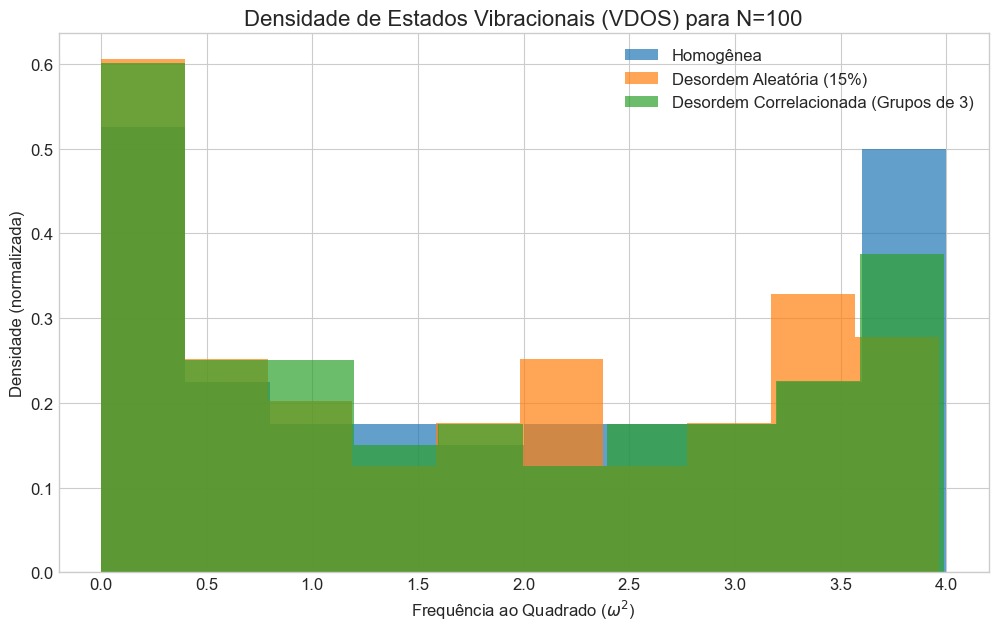


--- Iniciando análise de VDOS para N=1000 ---
Cálculos para N=1000 concluídos.


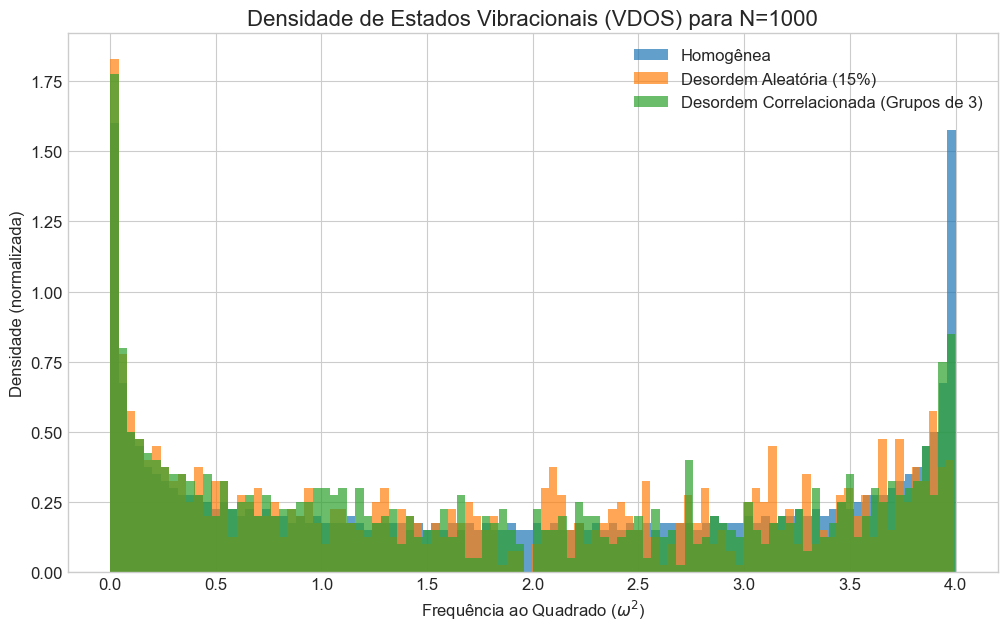


--- Iniciando análise de VDOS para N=10000 ---
Cálculos para N=10000 concluídos.


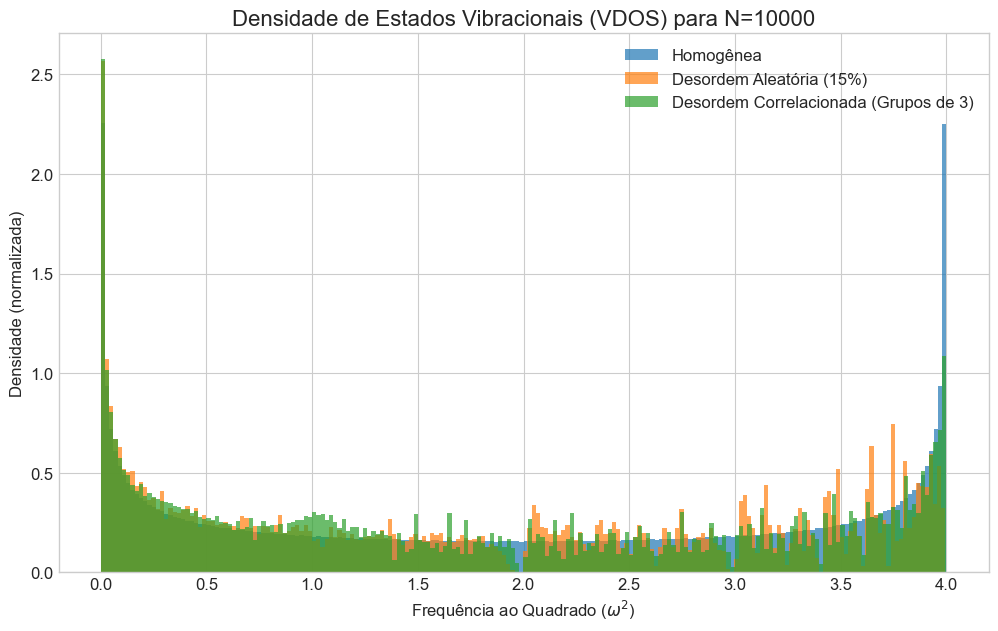

In [35]:
# --- TAREFA 3: DENSIDADE DE ESTADOS (VDOS) ---

N_valores = [100, 1000, 10000]
fracao_defeitos = 0.15
tamanho_grupo_correlacionado = 3

for N in N_valores:
    print(f"\n--- Iniciando análise de VDOS para N={N} ---")
    
    # Gerar cadeias
    m_hom = gerar_cadeia_massas(N, 0, 'homogenea')
    m_ale = gerar_cadeia_massas(N, fracao_defeitos, 'aleatoria')
    m_cor = gerar_cadeia_massas(N, fracao_defeitos, 'correlacionada', tamanho_grupo_correlacionado)
    
    # Resolver usando a função OTIMIZADA
    w2_hom = montar_e_resolver_otimizado(m_hom, k)
    w2_ale = montar_e_resolver_otimizado(m_ale, k)
    w2_cor = montar_e_resolver_otimizado(m_cor, k)
    print(f"Cálculos para N={N} concluídos.")
    
    # Plotar o histograma
    plt.figure(figsize=(12, 7))
    num_bins = int(N / 10) if N < 2000 else 200
    plt.hist(w2_hom, bins=num_bins, alpha=0.7, label='Homogênea', density=True)
    plt.hist(w2_ale, bins=num_bins, alpha=0.7, label=f'Desordem Aleatória ({int(fracao_defeitos*100)}%)', density=True)
    plt.hist(w2_cor, bins=num_bins, alpha=0.7, label=f'Desordem Correlacionada (Grupos de {tamanho_grupo_correlacionado})', density=True)
    
    plt.title(f'Densidade de Estados Vibracionais (VDOS) para N={N}', fontsize=16)
    plt.xlabel(r'Frequência ao Quadrado (${\omega}^2$)')
    plt.ylabel('Densidade (normalizada)')
    plt.legend()
    plt.grid(True)
    plt.show()

## 4. Resultados - Análise Detalhada dos Modos Normais (N=100)

Para investigar a natureza espacial das vibrações, realizamos uma análise detalhada dos autovetores para o caso N=100, que permite uma visualização clara dos modos individuais. Conforme solicitado, plotamos os **5 primeiros modos** (frequências mais baixas) e os **5 últimos modos** (frequências mais altas) para comparar o caráter espacial das vibrações entre a cadeia homogênea e a cadeia com desordem correlacionada.


--- Iniciando análise detalhada dos modos para N=100 ---


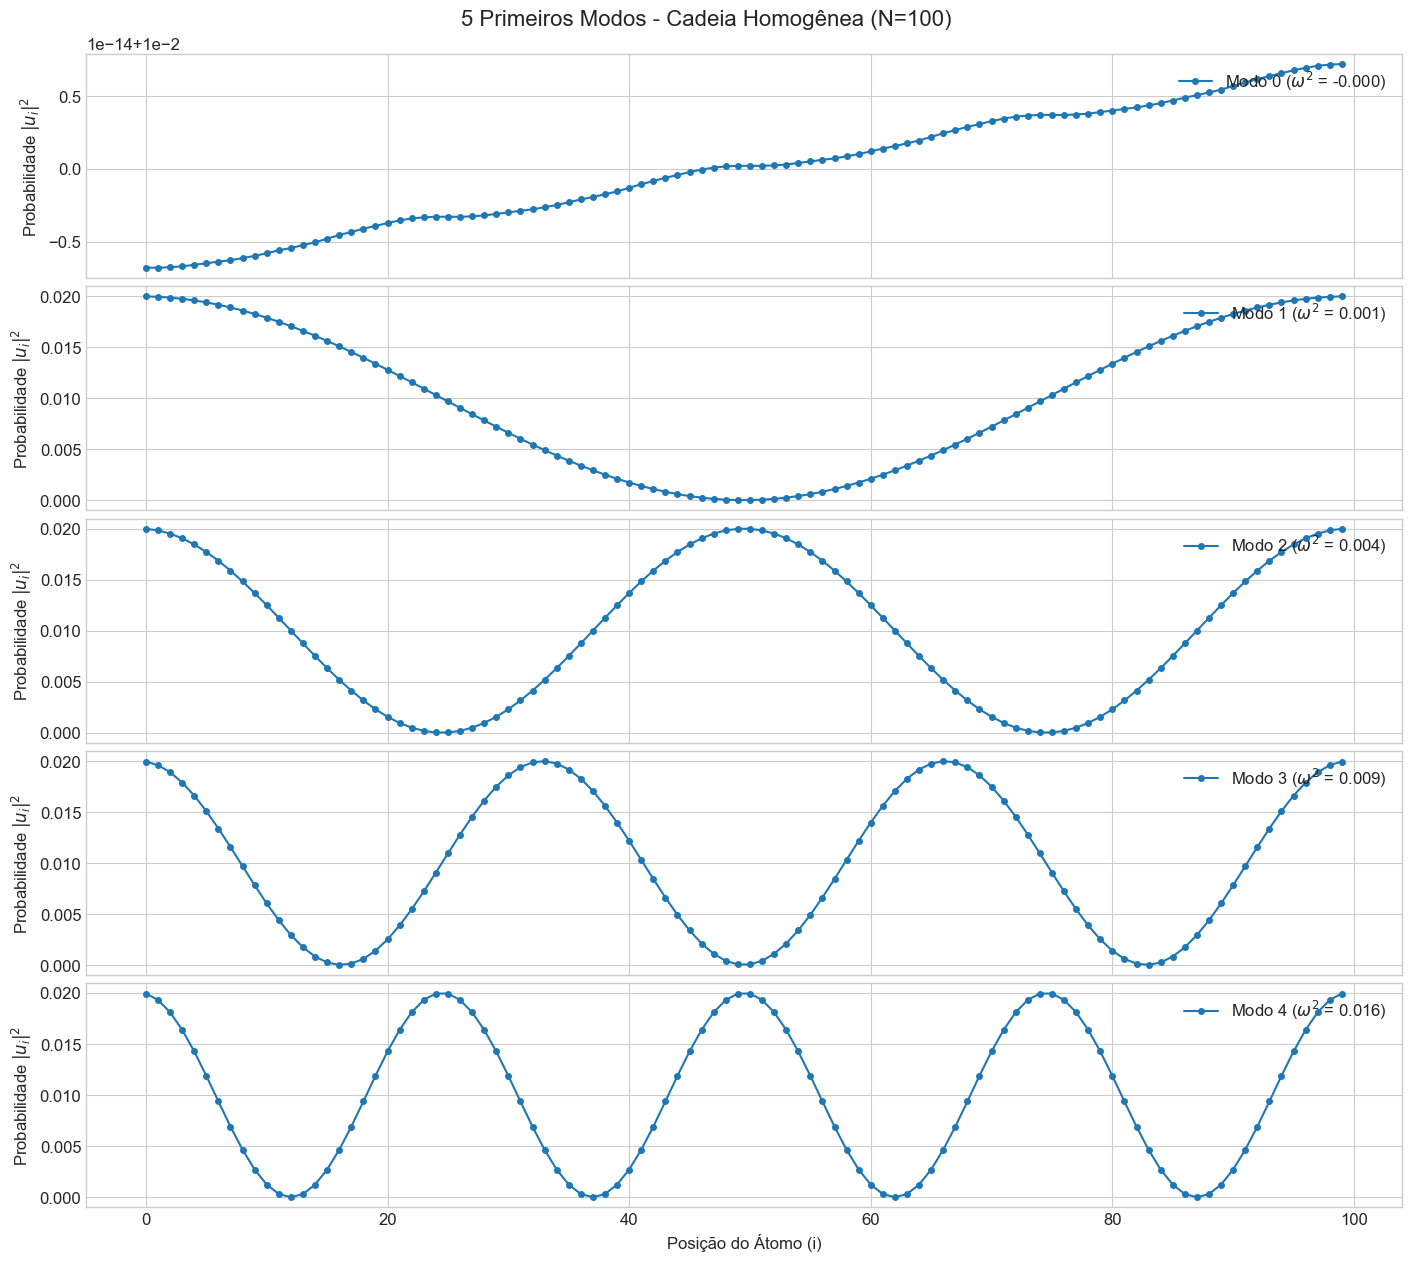

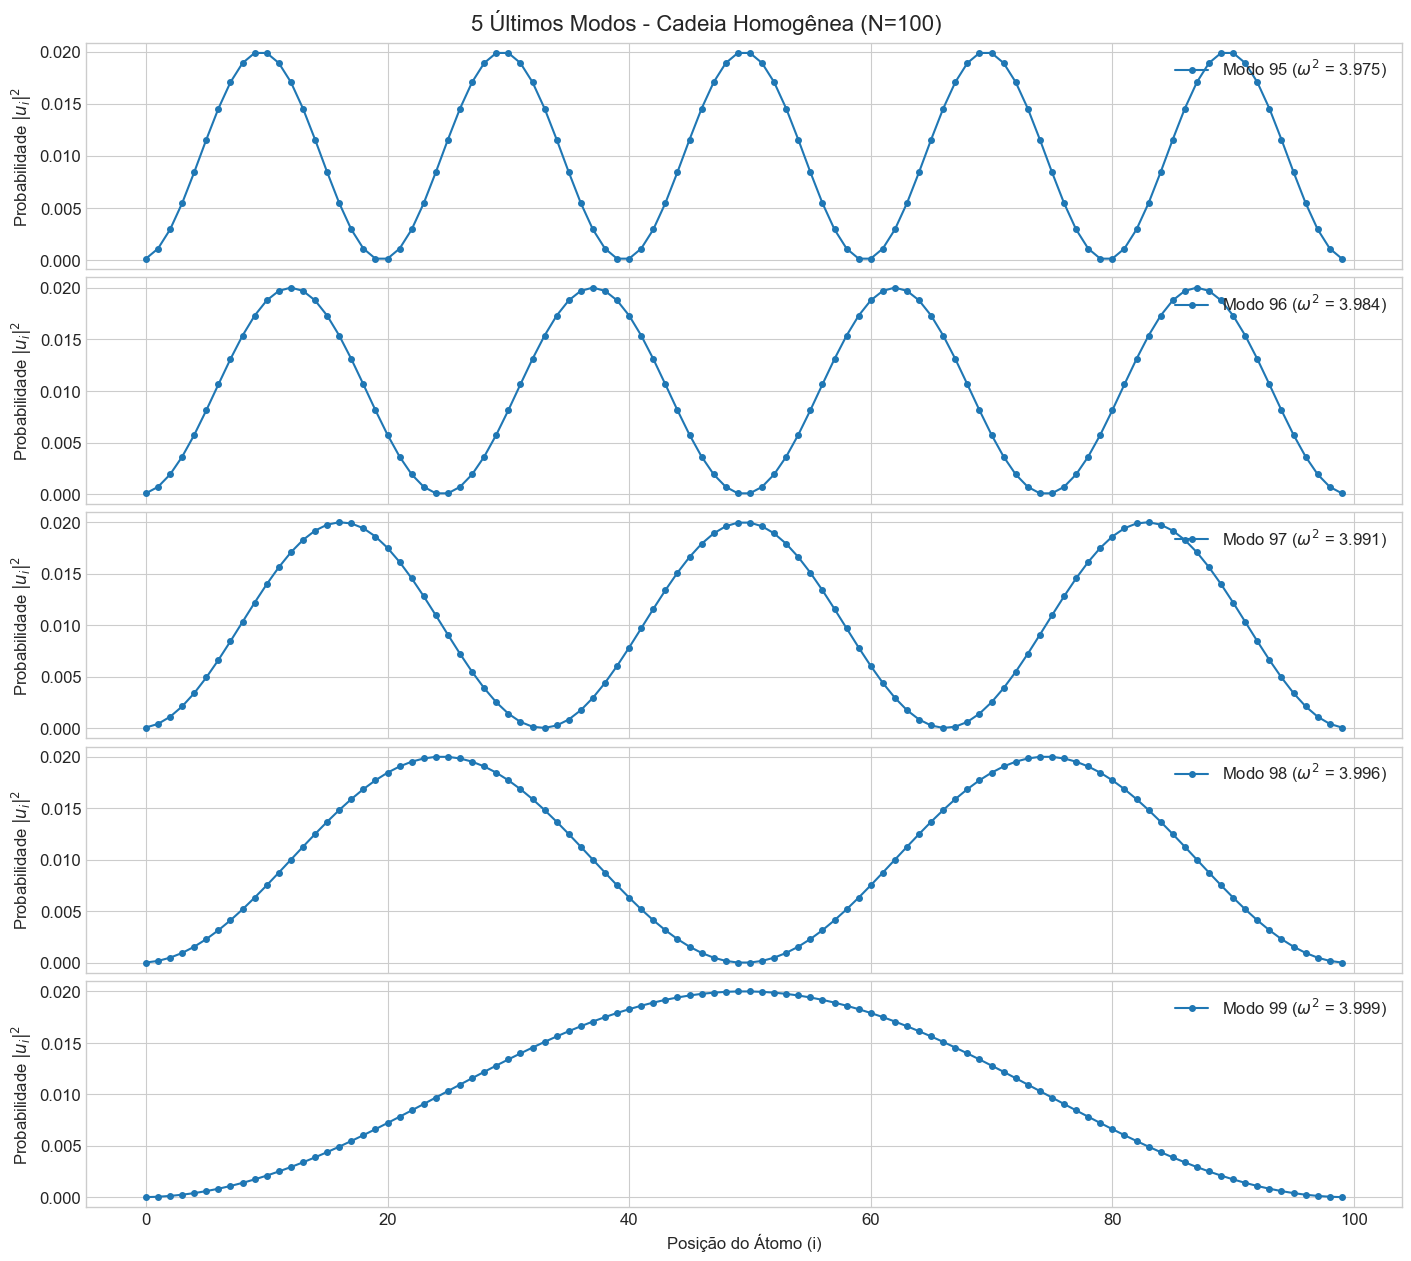

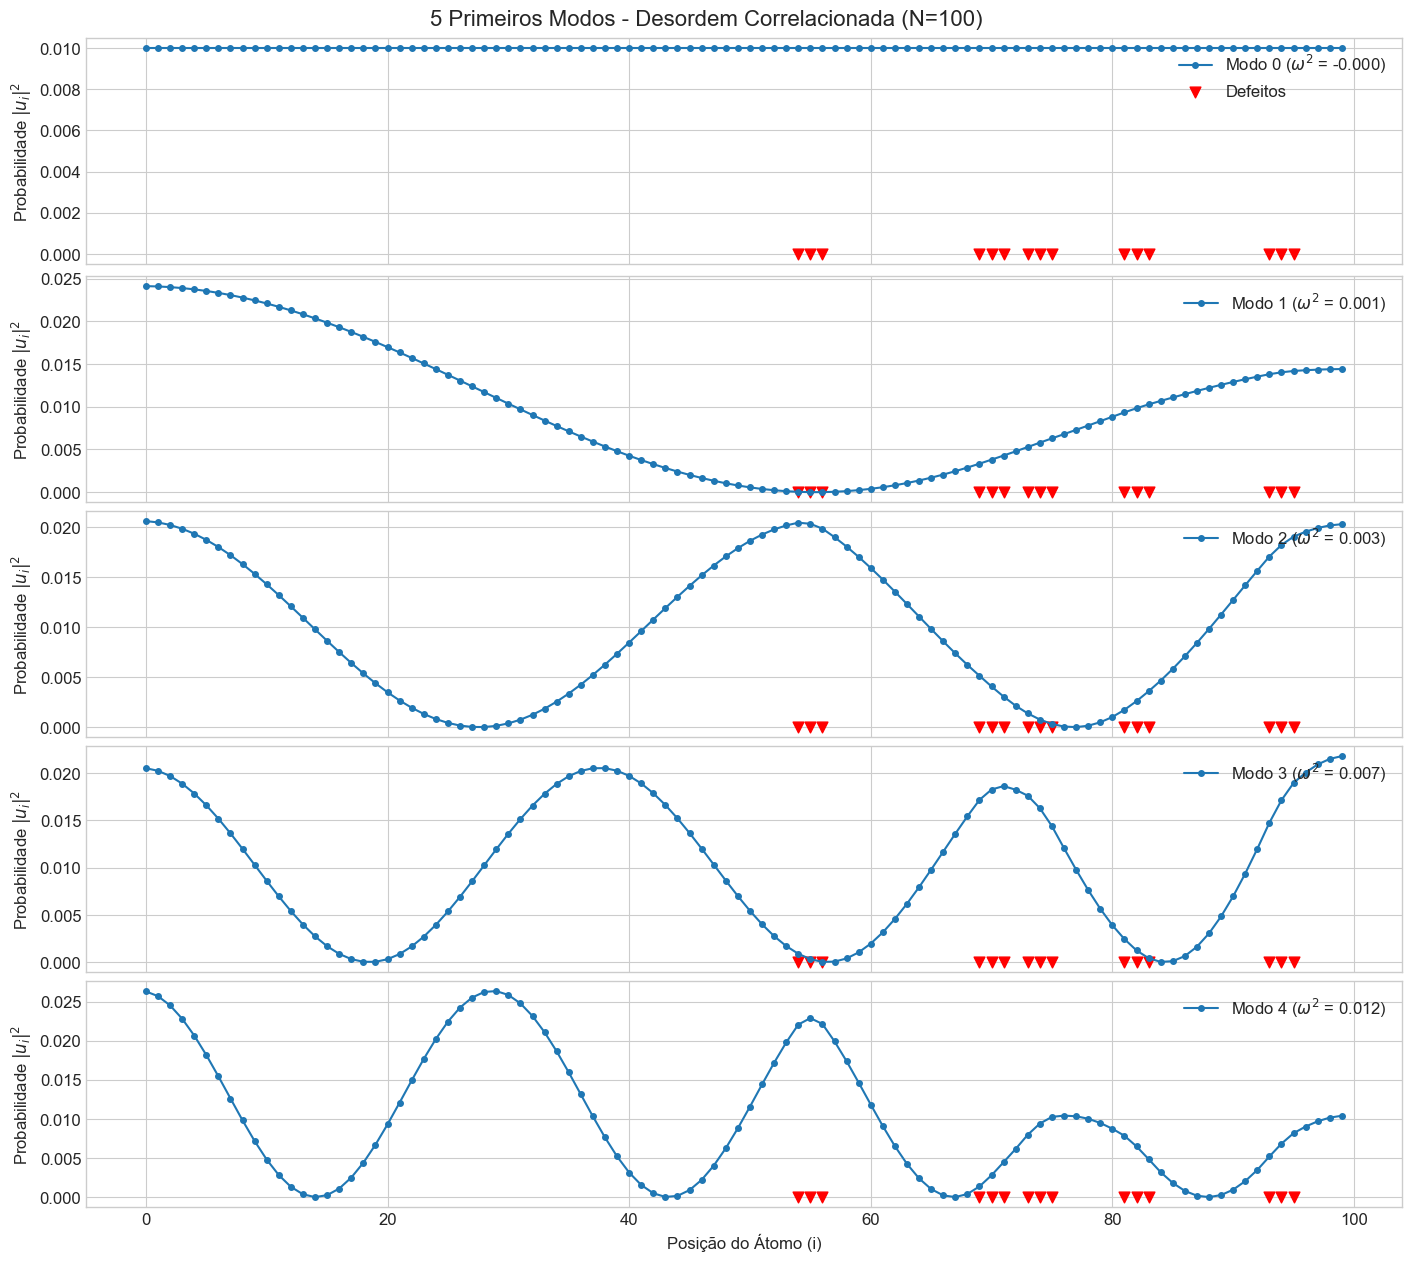

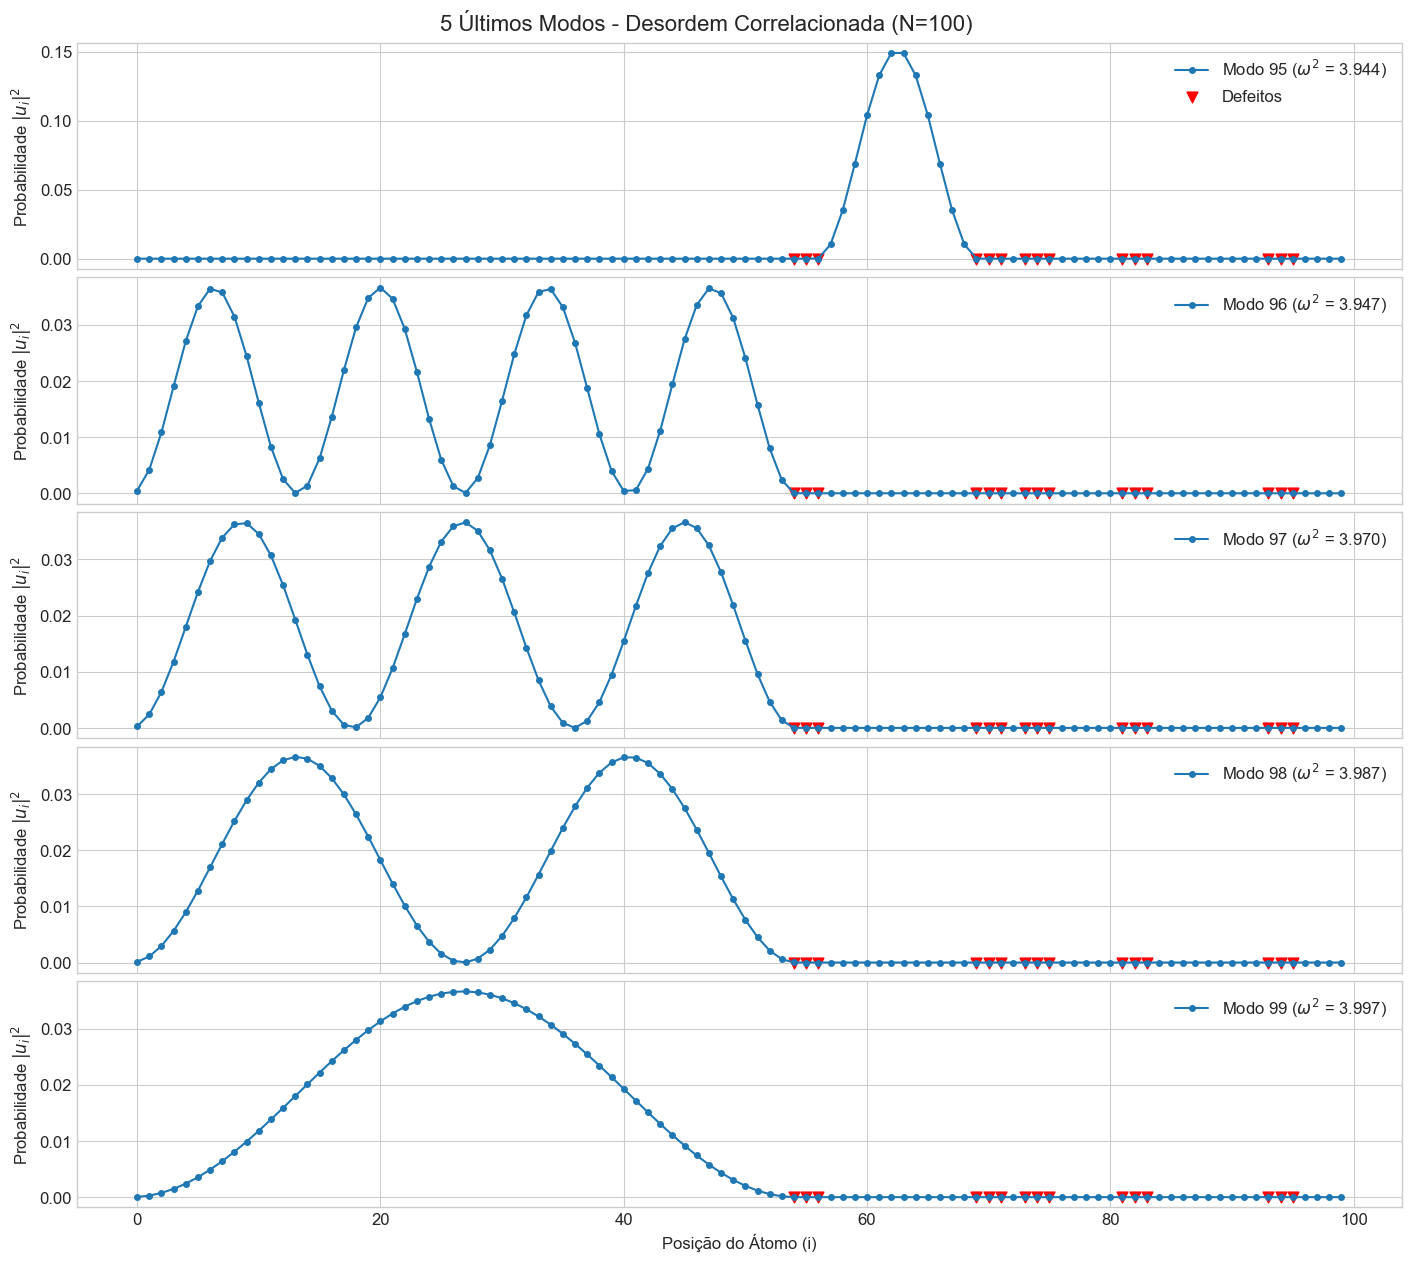


--- Análise completa. Todos os gráficos foram gerados. ---


In [36]:
# --- TAREFA 4: ANÁLISE DETALHADA DOS MODOS (N=100) ---
print("\n--- Iniciando análise detalhada dos modos para N=100 ---")

N_analise = 100

# Gere as cadeias para comparação
massas_homogenea_100 = gerar_cadeia_massas(N_analise, 0, 'homogenea')
massas_correlacionada_100 = gerar_cadeia_massas(N_analise, fracao_defeitos, 'correlacionada', tamanho_grupo_correlacionado)

# Resolva usando a função ORIGINAL para obter os autovetores (modos)
w2_hom_100, modos_hom_100 = montar_e_resolver_sistema(massas_homogenea_100, k)
w2_cor_100, modos_cor_100 = montar_e_resolver_sistema(massas_correlacionada_100, k)

# Índices dos modos a serem plotados
indices_baixos = list(range(5))             # 5 primeiros modos (0 a 4)
indices_altos = list(range(N_analise-5, N_analise)) # 5 últimos modos (95 a 99)

# --- Plot para o caso Homogêneo ---
plotar_modos(modos_hom_100, w2_hom_100, indices_baixos, massas_homogenea_100, '5 Primeiros Modos - Cadeia Homogênea (N=100)')
plotar_modos(modos_hom_100, w2_hom_100, indices_altos, massas_homogenea_100, '5 Últimos Modos - Cadeia Homogênea (N=100)')

# --- Plot para o caso com Desordem Correlacionada ---
plotar_modos(modos_cor_100, w2_cor_100, indices_baixos, massas_correlacionada_100, '5 Primeiros Modos - Desordem Correlacionada (N=100)')
plotar_modos(modos_cor_100, w2_cor_100, indices_altos, massas_correlacionada_100, '5 Últimos Modos - Desordem Correlacionada (N=100)')

print("\n--- Análise completa. Todos os gráficos foram gerados. ---")

## 5. Discussão dos Resultados

A análise dos resultados revela um comportamento físico rico e diferenças qualitativas marcantes entre os sistemas.

**Densidade de Estados:** Os gráficos de VDOS, especialmente para N=10.000, mostram que a desordem aleatória destrói as singularidades de Van Hove da cadeia perfeita, "borrando" o espectro. Em contraste, a desordem correlacionada preserva a forma geral da banda, indicando que a periodicidade de longo alcance não é completamente perdida. As "mordidas" e vales que surgem na VDOS correlacionada são a assinatura da interação ressonante das ondas com os clusters de defeitos.

**Natureza dos Modos:** A análise dos modos para N=100 é a chave para entender o fenômeno da localização.
- Nos **modos de baixa frequência**, observamos que os defeitos causam uma distorção nas ondas longas, mas elas permanecem estendidas por toda a cadeia.
- A mudança fundamental ocorre nos **modos de alta frequência**. O surgimento de modos como o **Modo 95** no caso correlacionado é a evidência clara da **localização de Anderson**. Este modo não é uma propriedade da cadeia como um todo, mas sim do cluster de defeito que o "aprisiona". Sua energia não se propaga, o que teria consequências drásticas para o transporte de calor, por exemplo. O fato de outros modos de alta frequência (96-99) permanecerem estendidos sugere que a localização depende de uma complexa ressonância entre a frequência do modo e a geometria do defeito.

## 6. Conclusão

Este trabalho demonstrou que a estrutura espacial da desordem é um fator determinante para as propriedades vibracionais de uma cadeia de osciladores. Concluímos que a desordem correlacionada, ao contrário da aleatória, permite a coexistência de dois regimes de vibração: fônons estendidos que se propagam de forma similar ao de um cristal perfeito (ainda que distorcidos) e modos de defeito fortemente localizados, que são uma assinatura direta dos clusters de impurezas.